In [1]:
import import_ipynb
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt
import os
import mlflow

from mlflow.models import infer_signature

# Import functions from other Jupyter notebook
import Utils.Time_Series_Classification_Helpers as ts_helpers
import Utils.Brain_Imaging_Classification_Helpers as bi_helpers
import Utils.Classification_Helpers as helpers

# Set Up MLFLow

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Import and Concatenate Data

In [3]:
subject_list = ["m292", "m294", "m298", "m299", "m300"]
label_list = [0, 1, 2, 3, 4]

## EEG/EMG Data

In [4]:
# Import dataframes that do not depend on folds
list_of_filenames = ["Topological_Summary_Statistics.csv", "Signature_Statistics.csv", "Advanced_Features.csv"]
#list_of_filenames = ["Statistical_Features.csv"]
time_series_feature_df = ts_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory="Time_Series")

## Brain Imaging

In [5]:
list_of_filenames = ["Topological_Summary_Statistics.csv", "Signature_Statistics.csv", "Advanced_Features.csv"]
#list_of_filenames = ["Traditional_Features.csv"]

_, subject_feature_df = bi_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory="Brain_Imaging")

brain_imaging_feature_df = bi_helpers.cut_dataframe_to_same_length_as_TS(subject_feature_df, subject_list)

## Merging

In [7]:
feature_df = helpers.merge_feature_dfs(time_series_feature_df, brain_imaging_feature_df)

## Preprocessing

In [8]:
feature_df.fillna(0, inplace=True)

## Save Features for Data Exploration

In [9]:
feature_df.to_csv("Features/All_Features.csv")

## Feature Engineering

In [10]:
print("There are "+str(len(feature_df.columns))+" features in the main dataframe.")

There are 2531 features in the main dataframe.


In [11]:
list_of_strings_in_column_names_to_remove = ["_Vectorization_Coordinate_"]

feature_df = helpers.remove_columns_with_str(feature_df, list_of_strings_in_column_names_to_remove)

print("There are "+str(len(feature_df.columns))+" features in the main dataframe after filtering.")

There are 131 features in the main dataframe after filtering.


# Cross Validation

In [12]:
# TODO This can be in the helper file as well
train_indices, validation_indices, test_indices = helpers.load_folds(subject_list, parent_directory = "Time_Series")

In [13]:
train_features_dfs_all_folds, train_labels_all_folds = helpers.filter_dataframe_with_indices(feature_df, train_indices, label_list)
validation_features_dfs_all_folds, validation_labels_all_folds = helpers.filter_dataframe_with_indices(feature_df, validation_indices, label_list)

## Reformat Data

In [14]:
X_train, y_train, X_test, y_test = helpers.initialize_fold_dicts(train_features_dfs_all_folds, train_labels_all_folds, validation_features_dfs_all_folds, validation_labels_all_folds)

In [15]:
np.save('Features/All_Train_Features.npy', \
            np.array(X_train, dtype=object), allow_pickle=True)

np.save('Features/All_Train_Labels.npy', \
            np.array(y_train, dtype=object), allow_pickle=True)


np.save('Features/All_Test_Features.npy', \
            np.array(X_test, dtype=object), allow_pickle=True)

np.save('Features/All_Test_Labels.npy', \
            np.array(y_test, dtype=object), allow_pickle=True)


# MLFLow

## Random Forest

In [16]:
# TODO use utils function again

params = {"random_state": 42, "n_estimators": 900, "min_samples_split": 2}
rf = RandomForestClassifier(**params)
all_accuracies = []
all_feature_importances = []

for fold in range(5):
    rf.fit(X_train[fold], y_train[fold])
    y_pred = rf.predict(X_test[fold])
    accuracy = accuracy_score(y_pred, y_test[fold])
    all_accuracies.append(accuracy)
    print("Accuracy for fold", fold + 1, ":", accuracy)

    
    feature_importances = rf.feature_importances_
    all_feature_importances.append(feature_importances)

average_accuracy = np.mean(all_accuracies)
print("Average Accuracy:", average_accuracy)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 1 : 0.95


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 2 : 0.9366666666666666


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 3 : 0.95


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 4 : 0.95
Accuracy for fold 5 : 0.9490909090909091
Average Accuracy: 0.9471515151515153


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


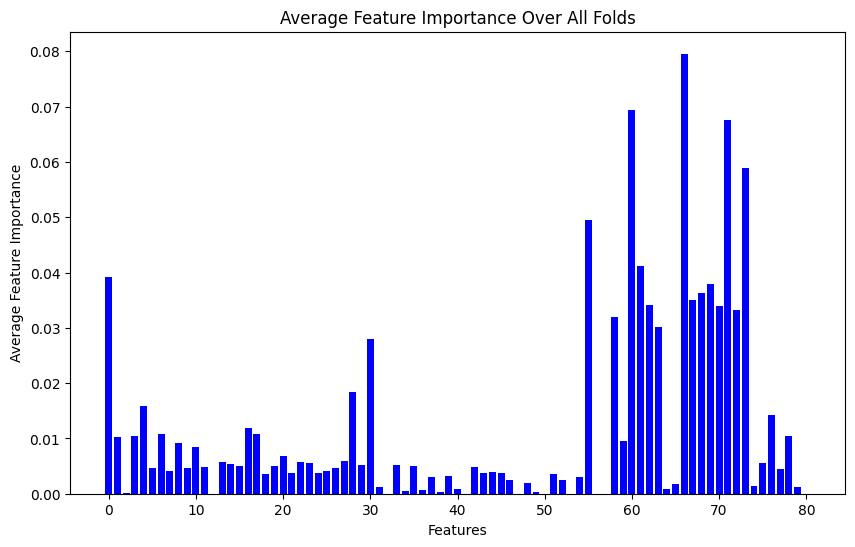

In [90]:
average_feature_importance = np.mean(all_feature_importances, axis=0)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_feature_importance)), average_feature_importance, color='b', align='center')
#plt.xticks(range(len(average_feature_importance)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance Over All Folds')
plt.show()

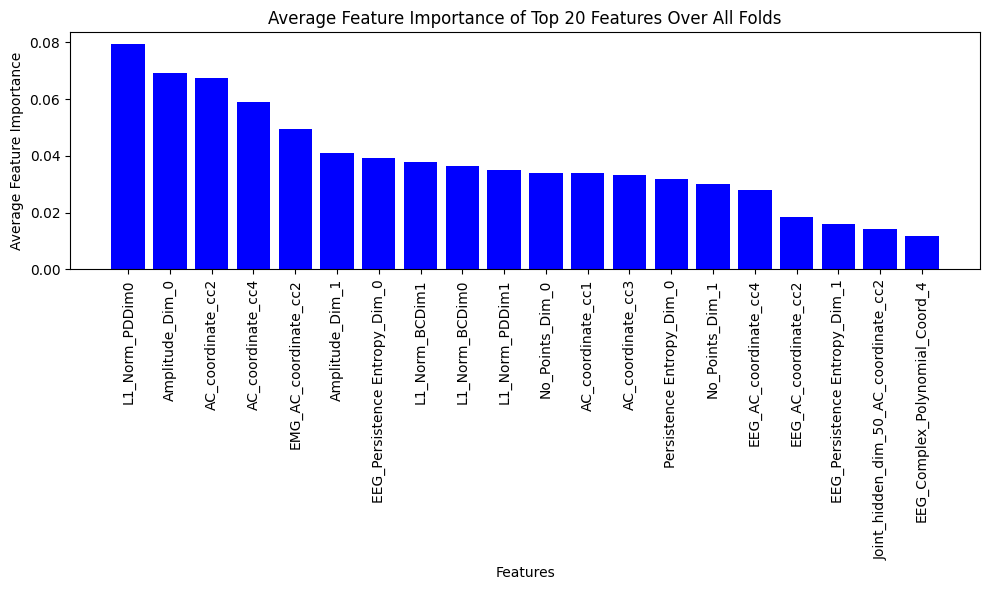

In [91]:
# Get indices of top 20 features with maximal importance
top_20_indices = np.argsort(average_feature_importance)[::-1][:20]

# Plotting feature importances for top 20 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_20_indices)), average_feature_importance[top_20_indices], color='b', align='center')
plt.xticks(range(len(top_20_indices)), X_train[fold].columns[top_20_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance of Top 20 Features Over All Folds')
# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.savefig('Top_feature_importances.png')  # Save as PNG
plt.show()

In [92]:
mlflow_params = params
features = X_train[0].columns
mlflow_params["features"] = features

In [93]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(mlflow_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", average_accuracy)
    mlflow.log_metric("minimal accuracy",  np.min(all_accuracies))
    mlflow.log_metric("maximal accuracy",  np.max(all_accuracies))

    # Log data
    mlflow.log_artifact("Features/All_Train_Features.npy")
    mlflow.log_artifact("Features/All_Train_Labels.npy")
    mlflow.log_artifact("Features/All_Test_Features.npy")
    mlflow.log_artifact("Features/All_Test_Labels.npy")
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Random Forest - Both Modalities")
    mlflow.set_tag('mlflow.runName', 'Random Forest - Both Modalities')


KeyboardInterrupt



## XGBoost

In [17]:
params = {"seed": 1, "learning_rate": 0.2, "n_estimators": 200, "max_depth": 4, "min_child_weight": 3, "min_child_weight": 0, "max_delta_step": 1, "subsample":0.5}
xb = xgb.XGBClassifier(**params)
all_accuracies = []
all_feature_importances = []

for fold in range(len(X_train)):
    # Remove duplicate columns
    X_train[fold] = helpers.keep_first_duplicate_columns(X_train[fold])

    xb.fit(X_train[fold], y_train[fold])

    X_test[fold] = X_test[fold].loc[:, ~X_test[fold].columns.duplicated()]

    y_pred = xb.predict(X_test[fold])
    accuracy = accuracy_score(y_pred, y_test[fold])
    all_accuracies.append(accuracy)
    print("Accuracy for fold", accuracy)

    # Get feature importances for the current fold
    feature_importances = xb.feature_importances_
    all_feature_importances.append(feature_importances)

average_accuracy = np.mean(all_accuracies)
print("Mean Accuracy:", average_accuracy)

Accuracy for fold 0.9833333333333333
Accuracy for fold 0.99
Accuracy for fold 0.99
Accuracy for fold 0.98
Accuracy for fold 0.9636363636363636
Mean Accuracy: 0.9813939393939393


In [ ]:
range_begin = 550
range_end = 600

average_feature_importance = np.mean(all_feature_importances, axis=0)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_feature_importance[range_begin:range_end])), average_feature_importance[range_begin:range_end], color='b', align='center')
plt.xticks(range(len(average_feature_importance[range_begin:range_end])), X_train[fold].columns[range_begin:range_end], rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance Over All Folds')
plt.savefig('All_feature_importances.png')  # Save as PNG
plt.show()
# Using all features - leaving out one feature

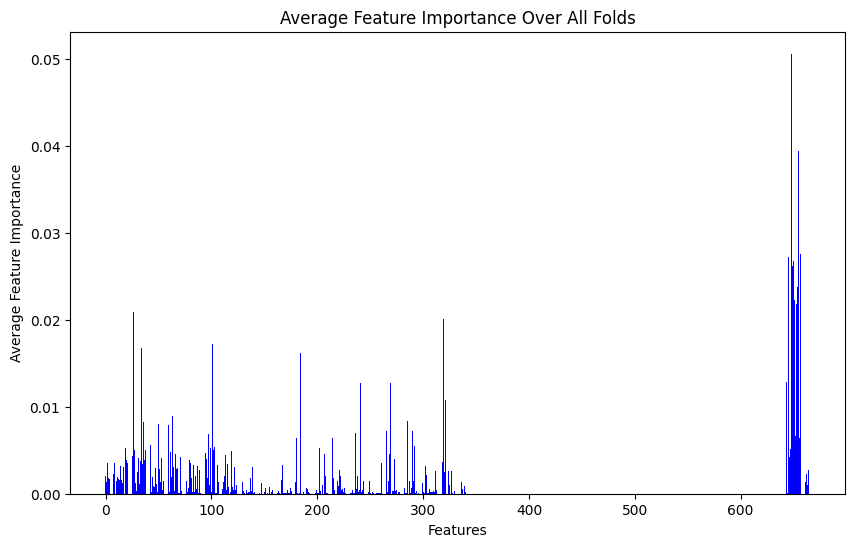

In [24]:
average_feature_importance = np.mean(all_feature_importances, axis=0)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_feature_importance)), average_feature_importance, color='b', align='center')
#plt.xticks(range(len(average_feature_importance)), X_train[fold].columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance Over All Folds')
plt.savefig('All_feature_importances.png')  # Save as PNG
plt.show()
# Using all features - leaving out one feature

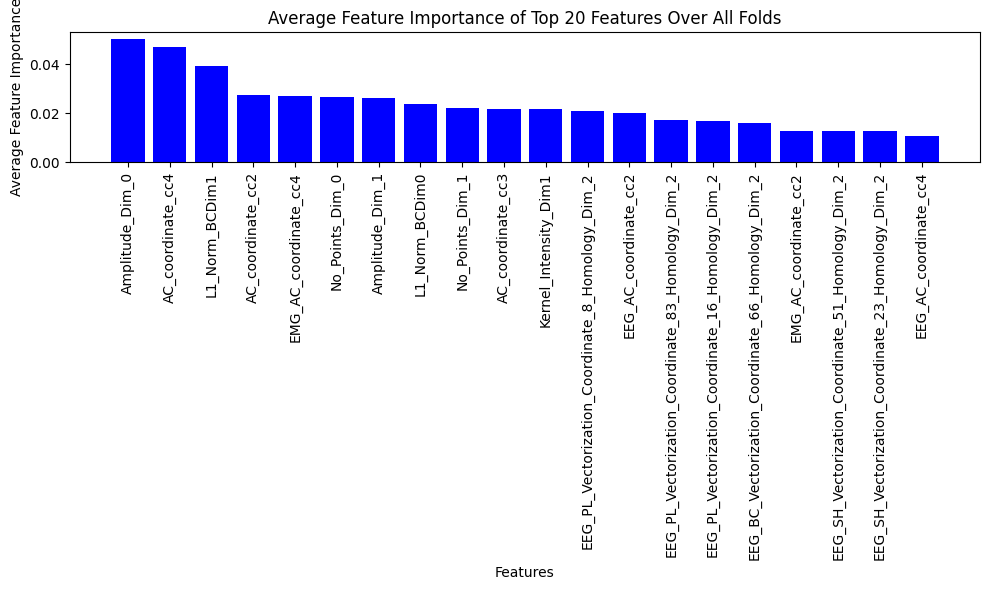

In [21]:
# Get indices of top 20 features with maximal importance
top_20_indices = np.argsort(average_feature_importance)[::-1][:20]

# Plotting feature importances for top 20 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_20_indices)), average_feature_importance[top_20_indices], color='b', align='center')
plt.xticks(range(len(top_20_indices)), X_train[fold].columns[top_20_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance of Top 20 Features Over All Folds')
# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.savefig('Top_feature_importances.png')  # Save as PNG
plt.show()

In [ ]:
mlflow_params = params
features = X_train[0].columns
mlflow_params["features"] = features

In [96]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(mlflow_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", average_accuracy)
    mlflow.log_metric("minimal accuracy",  np.min(all_accuracies))
    mlflow.log_metric("maximal accuracy",  np.max(all_accuracies))

    # Log data
    mlflow.log_artifact("Features/All_Train_Features.npy")
    mlflow.log_artifact("Features/All_Train_Labels.npy")
    mlflow.log_artifact("Features/All_Test_Features.npy")
    mlflow.log_artifact("Features/All_Test_Labels.npy")
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "XGBoost - Both Modalities")
    mlflow.set_tag('mlflow.runName', 'XGBoost - Both Modalities')

KeyboardInterrupt: 